In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm

from graph_generation import create_ER, dataset_nclass_ER
from models import GCN, GCNEmbed
from train import Trainer, Dataset
from embedding import Embedding
from experiments import experiment_embedding

import torch
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats

import yaml

In [2]:
config = yaml.safe_load(open("configs.yml"))

In [3]:
dataset_grafi_nx, dataset_labels, list_p= dataset_nclass_ER(config)

Mean connectivity for each node: 14.95 p=0.05
Mean connectivity for each node: 59.833 p=0.2
Mean connectivity for each node: 89.651 p=0.3
Mean connectivity for each node: 119.617 p=0.4
Mean connectivity for each node: 149.5 p=0.5
Mean connectivity for each node: 179.347 p=0.6


In [4]:
embeddings, trainer, test_loss_list = experiment_embedding(config, dataset_grafi_nx, dataset_labels, list_p)

GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 1)
  )
  (pools): ModuleList(
    (0): TopKPooling(32, ratio=0.8, multiplier=1.0)
    (1): TopKPooling(32, ratio=0.8, multiplier=1.0)
    (2): TopKPooling(1, ratio=0.8, multiplier=1.0)
  )
  (leaky): LeakyReLU(negative_slope=0.03)
)
MSELoss()
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [03:53<00:00,  7.71it/s]


Tempo impiegato: 234.02391624450684
runs/lr-0.01_epochs500_bs250_neurons-1-32-32-1/09Jun_13-56-00
Run training for 500 epochs
Epoch: 0	Test loss: 0.0002727036674817403 	 Explained Variance: nan
Epoch: 5	Test loss: 0.00016734637664975944 	 Explained Variance: nan
Epoch: 10	Test loss: 0.00016520001270152904 	 Explained Variance: nan
Epoch: 15	Test loss: 0.0001731133122962934 	 Explained Variance: nan
Epoch: 20	Test loss: 0.00017269510706817662 	 Explained Variance: nan
Epoch: 25	Test loss: 0.00016552467175104 	 Explained Variance: nan
Epoch: 30	Test loss: 0.00016504766902437917 	 Explained Variance: nan
Epoch: 35	Test loss: 0.0001647511911061075 	 Explained Variance: nan
Epoch: 40	Test loss: 0.00016568955723886137 	 Explained Variance: nan
Epoch: 45	Test loss: 0.00016604583986379483 	 Explained Variance: nan
Epoch: 50	Test loss: 0.00017588741180521472 	 Explained Variance: nan
Epoch: 55	Test loss: 0.00017022033463473673 	 Explained Variance: nan
Epoch: 60	Test loss: 0.0001653124129882565

In [15]:
embeddings.embeddings_array.shape

(1800, 1)

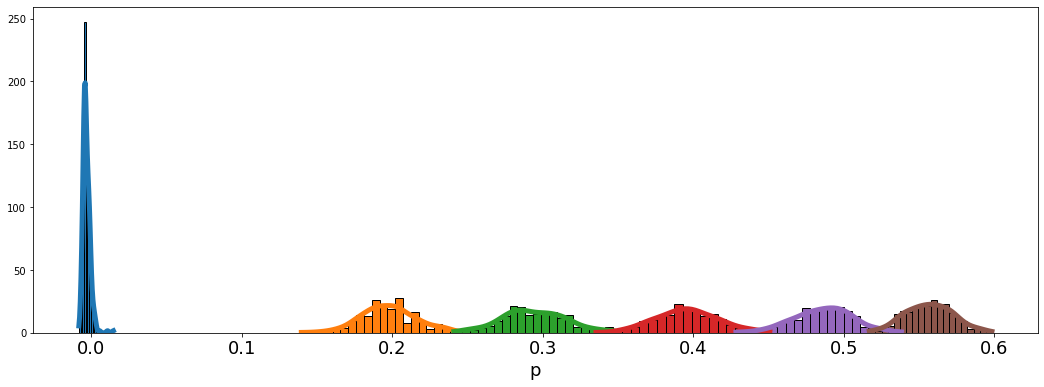

In [16]:
def intorno(p_teorica, p_attuali, soglia):
    mask = []
    for p in p_attuali:
        if p > p_teorica - soglia and p < p_teorica + soglia:
            mask.append(True)
        else:
            mask.append(False)
    return mask
    
plt.figure(figsize=(18, 6)) #, dpi=60)
for p in list_p:
    #mask_int = np.argwhere(embeddings.embedding_labels==p).flatten()
    mask_int = np.argwhere(intorno(p, embeddings.embedding_labels, 0.05)).flatten()
    emb = embeddings.embeddings_array[mask_int].flatten()
    
    h,e = np.histogram(emb, bins=20, density=True)
    x = np.linspace(e.min(), e.max())
    plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

    kde = stats.gaussian_kde(emb)
    plt.plot(x, kde.pdf(x),  lw=5, label='KDE')
    
plt.xlabel('p', fontsize=18)
plt.xticks(fontsize=18) 
plt.show()

In [7]:
import networkx as nx
num_nodes = config['graph_dataset']['Num_nodes']
#total_links = num_nodes* (num_nodes-1) / 2
actual_p = np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() / (num_nodes-1) for t in trainer.dataset.dataset])

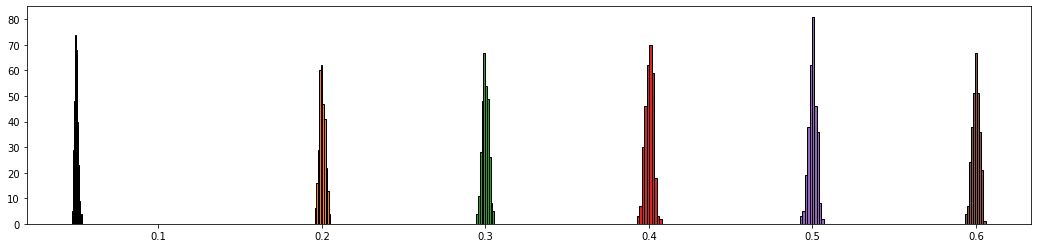

In [18]:
plt.figure(figsize=(18, 4)) #, dpi=60)
for p in list_p:
    #mask_int = np.argwhere(embeddings.embedding_labels==p).flatten()
    mask_int = np.argwhere(intorno(p, embeddings.embedding_labels, 0.05)).flatten()
    h,e = np.histogram(actual_p[mask_int], bins=10, density=False)
    x = np.linspace(e.min(), e.max())
    plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')
plt.show()

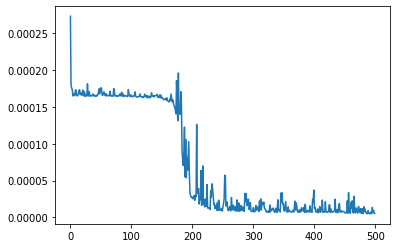

In [19]:
plt.plot(test_loss_list)

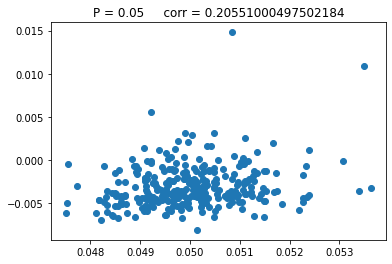

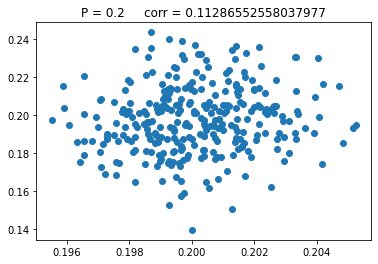

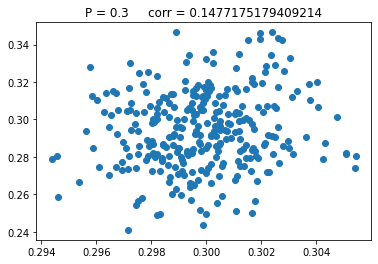

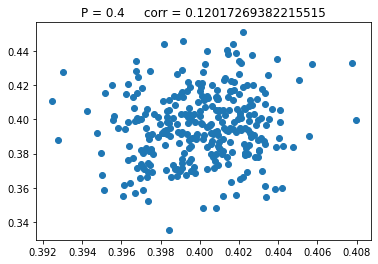

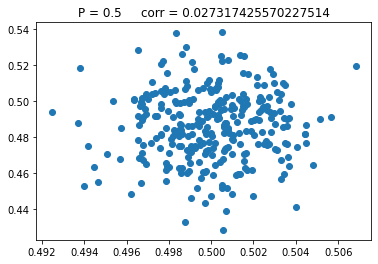

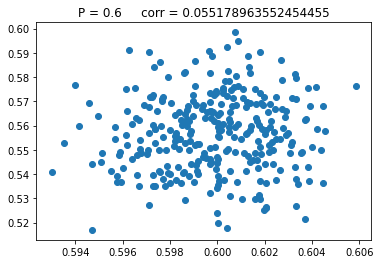

In [20]:
#plt.figure(figsize=(18, 6)) #, dpi=60)
for p in list_p:
    mask_int = np.argwhere(intorno(p, embeddings.embedding_labels, 0.05)).flatten()
    plt.scatter(actual_p[mask_int], embeddings.embeddings_array[mask_int].flatten()) #, s=area, c=colors, alpha=0.5)
    # correlazione tra target e prediction
    correlaz = np.corrcoef(embeddings.embeddings_array[mask_int].flatten(), actual_p[mask_int])[0,1]
    plt.title(f"P = {p}     corr = {correlaz}")
    plt.show()

# Vedo cosa fa su altri grafi che non ha mai visto, con p diversa

In [11]:
config['graph_dataset']['list_p'] = [0.03, 0.2]
dataset_grafi_nx, dataset_labels, list_p = dataset_nclass_ER(config)
trainer.load_dataset(dataset_grafi_nx, dataset_labels)
whole_data = trainer.dataset.dataset_pyg
all_data_loader = DataLoader(whole_data, batch_size=trainer.dataset.bs, shuffle=False) 
embeddings_array2 = trainer.take_embedding(all_data_loader)
embeddings_array2 = np.array([emb.cpu().detach().numpy() for emb in embeddings_array2])

embeddings2 = Embedding(embeddings_array2, trainer.dataset.dataset, trainer.dataset.labels, list_p)

Mean connectivity for each node: 8.964 p=0.03
Mean connectivity for each node: 59.795 p=0.2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:28<00:00, 21.04it/s]


Tempo impiegato: 28.583576440811157


<BarContainer object of 30 artists>

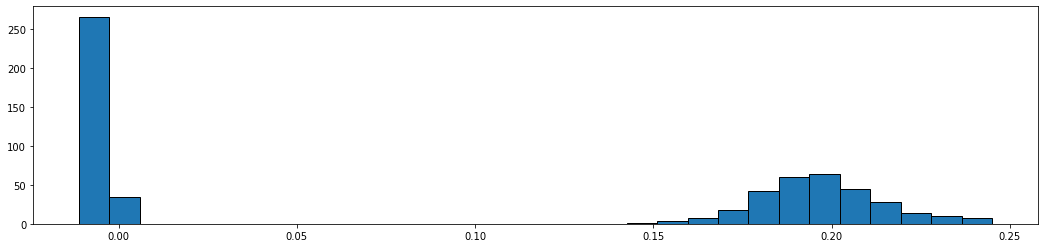

In [12]:
plt.figure(figsize=(18, 4))
h,e = np.histogram(embeddings2.embeddings_array.flatten(), bins=30, density=False)
x = np.linspace(e.min(), e.max())
plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

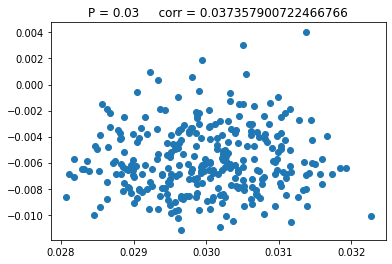

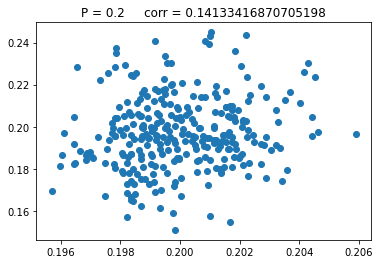

In [13]:
actual_p2 = np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() / (num_nodes-1) for t in trainer.dataset.dataset])
for p in list_p:
    mask_int = np.argwhere(intorno(p, embeddings2.embedding_labels, 0.15)).flatten()
    plt.scatter(actual_p2[mask_int], embeddings2.embeddings_array[mask_int].flatten()) #, s=area, c=colors, alpha=0.5)
    # correlazione tra target e prediction
    correlaz = np.corrcoef(embeddings2.embeddings_array[mask_int].flatten(), actual_p2[mask_int])[0,1]
    plt.title(f"P = {p}     corr = {correlaz}")
    plt.show()